In [123]:
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [124]:
# load data
headlines_file = 'data/Sarcasm_Headlines_Dataset_v2.json'
df = pd.read_json(headlines_file, lines = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [125]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [126]:
# check for duplicate rows
df.loc[df.duplicated() == True]

,is_sarcastic,headline,article_link
18572,0,hillary clinton vs. herself,https://www.huffingtonpost.comhttp://nymag.com...
25743,1,nation not sure how many ex-trump staffers it ...,https://politics.theonion.com/nation-not-sure-...


In [127]:
# remove duplicates
df.drop_duplicates(inplace=True, ignore_index = True)

# drop article link column, don't need it
df.drop(columns=['article_link'], inplace=True)

In [128]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


### Check if dataset is balanced

              headline
is_sarcastic          
0                14984
1                13633


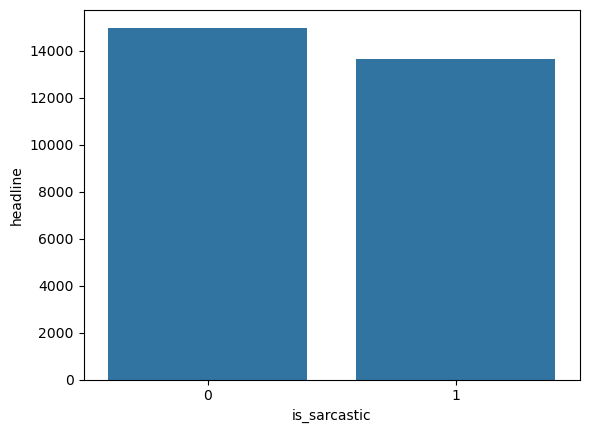

In [129]:
# group by label
group_obj = df.groupby('is_sarcastic')
print(group_obj.count())

# bar plot to visualize
sns.barplot(group_obj.agg('count')['headline']);

In [130]:
# check the spread of headlines length
df['headline'].str.len().describe()

count    28617.000000
mean        62.309711
std         20.726151
min          7.000000
25%         49.000000
50%         62.000000
75%         75.000000
max        926.000000
Name: headline, dtype: float64

<Axes: ylabel='headline'>

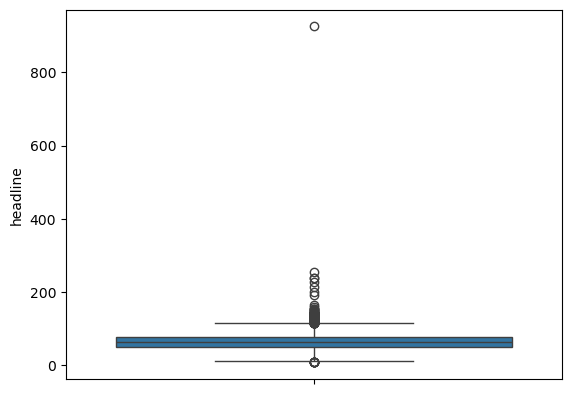

In [131]:
sns.boxplot(df['headline'].str.len())

### Above box plot shows some outliers, let's clean that

In [132]:
# add length column
df['length'] = df['headline'].str.len()

# calculate Q1, Q3 and IQR
Q1 = df['length'].quantile(0.25)
Q3 = df['length'].quantile(0.75)
IQR = Q3 - Q1

# find lower and upper bounds beyond which outliers exist
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# remove outliers
df_cleaned = df[(df['length'] >= lower_bound) & (df['length'] <= upper_bound)]

# drop length column, it's job is done
df_cleaned = df_cleaned.drop(columns='length')

print("Origina shape of DataFrame:", df.shape)
print("DataFrame shape after cleaning :", df_cleaned.shape)

Origina shape of DataFrame: (28617, 3)
DataFrame shape after cleaning : (28313, 2)


In [133]:
df_cleaned.headline.str.len().describe()

count    28313.000000
mean        61.629146
std         18.980705
min         10.000000
25%         49.000000
50%         62.000000
75%         74.000000
max        114.000000
Name: headline, dtype: float64

### Prepare data

In [134]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize the lemmatizer and get the list of stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function for tokenization, stop word removal and lemmatization
def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only letters and spaces
    # Tokenization
    tokens = word_tokenize(text.lower()) # Convert to lower case
    # Remove stop words and lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(cleaned_tokens)

[nltk_data] Downloading package punkt_tab to /home/codez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/codez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/codez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [135]:
df_prepared = df_cleaned.copy()
df_prepared['headline'] = df_cleaned['headline'].apply(preprocess_text)

df_prepared

,is_sarcastic,headline
0,1,thirtysomething scientist unveil doomsday cloc...
1,0,dem rep totally nail congress falling short ge...
2,0,eat veggie deliciously different recipe
3,1,inclement weather prevents liar getting work
4,1,mother come pretty close using word streaming ...
...,...,...
28612,1,jew celebrate rosh hashasha something
28613,1,internal affair investigator disappointed cons...
28614,0,beautiful acceptance speech week came queer ko...
28615,1,mar probe destroyed orbiting spielberggates sp...


In [136]:
X_train, X_test, y_train, y_test = train_test_split(df_prepared['headline'], df_prepared['is_sarcastic'], test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19819,), (8494,), (19819,), (8494,))

### Create and train models

In [137]:
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [138]:
# Vectorize text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# List of models to train
models = {
'Logistic Regression': LogisticRegression(max_iter=1000),
'Naive Bayes': MultinomialNB(),
'Random Forest': RandomForestClassifier(),
'SVM': SVC()
}


In [139]:
results = {}
predictions = {}

# train and evaluate models
for model_name, model in models.items():
    start_time = time()
    model.fit(X_train_vec, y_train)
    end_time = time()
    y_pred = model.predict(X_test_vec)

    # evaluate
    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'time': end_time - start_time
    }

results_df = pd.DataFrame(results).T
results_df.head()

,accuracy,f1_score,precision,recall,time
Logistic Regression,0.788321,0.768835,0.797546,0.742120,3.697814
Naive Bayes,0.795738,0.781898,0.792155,0.771904,0.006389
Random Forest,0.753591,0.702572,0.821809,0.613552,16.974435
SVM,0.784789,0.753904,0.823772,0.694962,37.560981


### plot metrics

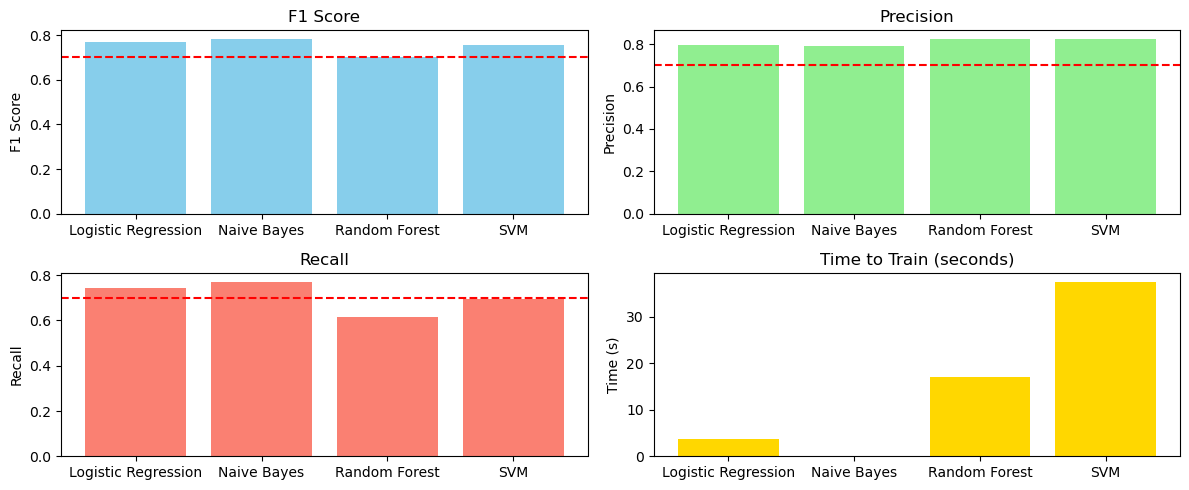

In [140]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 5))

# F1 Score
axs[0, 0].bar(results_df.index, results_df['f1_score'], color='skyblue')
axs[0, 0].set_title('F1 Score')
axs[0, 0].set_ylabel('F1 Score')
axs[0, 0].axhline(y=0.7, color='r', linestyle='--')  # Линия для 70%

# Precision
axs[0, 1].bar(results_df.index, results_df['precision'], color='lightgreen')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].axhline(y=0.7, color='r', linestyle='--')

# Recall
axs[1, 0].bar(results_df.index, results_df['recall'], color='salmon')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].axhline(y=0.7, color='r', linestyle='--')

axs[1, 1].bar(results_df.index, results_df['time'], color='gold')
axs[1, 1].set_title('Time to Train (seconds)')
axs[1, 1].set_ylabel('Time (s)')

plt.tight_layout()
plt.show()

All models show good results, but the Random Forest model has less recall. SVM takes a lot of time to train compared to other models.

According to the obtained metrics, the Naive Bayes model seems to perform best.

Let's try to calculate the KPI of models for automatic selection of the best one.

In [141]:
def best_model(results_df):

    # normalize time
    results_df['normalized_time'] = (results_df['time'] - results_df['time'].min()) / (results_df['time'].max() - results_df['time'].min())

    # calculate KPI
    results_df['KPI'] = (results_df['accuracy'] +
                     results_df['f1_score'] +
                     results_df['precision'] +
                     results_df['recall'] -
                     results_df['normalized_time'])
    print(results_df)

    # model with max KPI
    best_model_index = results_df['KPI'].idxmax()
    best_model = results_df.loc[best_model_index]
    print("")
    print("*"*100)
    print("best model:")
    print(best_model.name)

    return best_model

model=best_model(results_df)

                     accuracy  f1_score  precision    recall       time  \
Logistic Regression  0.788321  0.768835   0.797546  0.742120   3.697814   
Naive Bayes          0.795738  0.781898   0.792155  0.771904   0.006389   
Random Forest        0.753591  0.702572   0.821809  0.613552  16.974435   
SVM                  0.784789  0.753904   0.823772  0.694962  37.560981   

                     normalized_time       KPI  
Logistic Regression         0.098295  2.998527  
Naive Bayes                 0.000000  3.141695  
Random Forest               0.451823  2.439700  
SVM                         1.000000  2.057427  

****************************************************************************************************
best model:
Naive Bayes
